In [1]:
import numpy as np
import scipy.optimize as so
import matplotlib.pylab as plt

plt.style.use('fast') #alt: 'seaborn-white'

#plt.rcParams.update({'font.size': 20, 'font.family': 'serif', 'font.weight':'normal'})
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = "serif"
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['xtick.direction'] = "in"
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['ytick.direction'] = "in"
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['mathtext.fontset'] = "cm"

In [2]:
from integrators.common import rk4
import integrators.contact as ci

In [3]:
class Osc:
    def __init__(self, gamma, C=0):
        self.gamma = gamma
        self.C = C
    
    def V(self, x, t):
        return 0.5 * x**2 - self.C
    def Vq(self, x, t):
        return x
    def f(self, t):
        return self.gamma

# Contact integrators

The integrator for the quadratic oscillator case is implicit. You can see the implementations below.

In [4]:
def quadratic_v(init, tspan, a, C=0):
    p0, q0, s0 = init
    osc = Osc(a, C)
    return ci.integrate(ci.variational_step_quadratic, osc, tspan, p0, q0, s0)

def quadratic_h(init, tspan, a):
    p0, q0, s0 = init
    osc = Osc(a)
    return ci.integrate(ci.step1q, osc, tspan, p0, q0, s0)

# Euler-type integrators

In [5]:
osc = lambda p,x,z,t,a: -x-a*p*z

def rk4s(init, tspan, a, h, acc, C=0):
    t = tspan
    lag = lambda p,q,z: p**2/2.0 - q**2/2.0 + C - a*z**2/2.0
    def derivs(x,t):
        dp = acc(x[0],x[1],x[2],0,a)
        dq = x[0]
        dz = lag(x[0],x[1],x[2])
        return (dp, dq, dz)
    return rk4(derivs, init, t)

#explicit midpoint
def midpoint(init, tspan, a, h, acc, C=0):
    steps = len(tspan)
    hsq = np.math.pow(h,2)
    lacc = lambda p,q,z: acc(p,q,z,0,a)
    lag = lambda p,q,z: p**2/2.0 - q**2/2.0 + C - a*z**2/2.0
    
    sol = np.empty([steps, 3], dtype=np.float64)
    sol[0] = np.array(init)
    for i in range(steps-1):
        p,x,z = sol[i]
        half = h/2.0
        pmid = p + half*lacc(p, x, z)
        xmid = x + half*p
        zmid = z + half*lag(p, x, z)
        
        pnew = p + h*lacc(pmid, xmid, zmid)
        xnew = x + h*pmid
        znew = z + h*lag(pmid, xmid, zmid)
        sol[i+1] = np.array([pnew, xnew, znew])
    return sol

# Symplectic integrators (hand adapted)

In this case symplectic integrators cannot be applied as-is. One should introduce a dummy variable to make the system even-dimensional again. Below we add some hand crafted implementations for the comparisons.

_Note that the comparison will not be very meaningful in this case, so we decided to omit it from the paper._

In [6]:
def leapfrog(init, tspan, a, h, acc):
    steps = len(tspan)
    hsq = np.math.pow(h,2)
    lacc = lambda p,q,z: acc(p,q,z,0,a)
    
    sol = np.empty([steps, 3], dtype=np.float64)
    sol[0] = np.array(init)
    for i in range(steps-1):
        p,x,z = sol[i]
        xnew = x + h*p + hsq/2.0*lacc(p, x, z)
        znew, = so.fsolve(
            lambda znew: z - znew + h*(.5*((xnew-x)/h)**2 - .25*(x**2 + xnew**2) - .25*a*(z**2 + znew**2))
            , z
        )
        pnew = p + h*(lacc(p, x, z) + lacc(p, xnew, znew))/2.0
        sol[i+1] = np.array([pnew, xnew, znew])
    
    return sol

In [7]:
def relerr(ref, sol, shift=10.0):
    """
    Regularized relative error between the reference solution
    and the approximation: abs((shift+sol)/(shift+ref)-1.0)
    As the solutions that we are going to discuss have often a very
    small magnitude, we shift the solutions from 0 to avoid division
    by zero errors. We chose this function to emphasize the relative
    size of the error compared to the solution.
    """
    return np.abs((shift+sol)/(shift+ref)-1.0)/3.0

In [8]:
def cmp_plot(init, tspan, a, h, delta, acc=osc, save=False, full=False):
    
    t0, tf = tspan
    ts = np.arange(t0, tf, h)
    tsfine = np.arange(t0, tf, h/delta)
    
    r = rk4s(init, tsfine, a, h/delta, acc)

    s1pq, s1s, _ = quadratic_v(init, ts, a)
    s2pq, s2s, _ = quadratic_h(init, ts, a)
    s4 = midpoint(init, ts, a, h, acc)
    
    if full:
        s3 = ci.vaariational_quadratic_implicit(init, ts, a, h)
        s5 = leapfrog(init, ts, a, h, acc)
    
    # This may be needed when the time step or the delta are not even
    rtrim = r[::delta,1]
    rtrim = rtrim[:len(ts)]
    r2trim = r[::delta,2]
    r2trim = r2trim[:len(ts)]
        
    plt.figure(figsize=(20,20))    
    
    plt.subplot(411)
    plt.title("Solution for $h={}$, $\\alpha={}$, $(p_0,q_0,z_0)={}$".
              format(h, a, tuple(init))
             )
    plt.plot(ts, s1pq[:,1], label="Contact (1st)", linestyle="--", linewidth=.5)
    if full:
        plt.plot(ts, s3[:,1], label="Contact (2nd)", linestyle="-.", linewidth=.5)
    plt.plot(ts, s2pq[:,1], label="Contact (H 2nd)", linestyle="--", linewidth=.5)
    plt.plot(ts, s4[:,1], label="Explicit midpoint (2nd)", linestyle=":", linewidth=.8)
    if full:
        plt.plot(ts, s5[:,1], label="Leapfrog", linestyle=":", linewidth=.5)
    plt.plot(tsfine[:len(r[:,1])], r[:,1], label="Reference", linestyle="-", linewidth=.5)
    plt.legend()
    plt.xlabel("$t$")
    plt.ylabel("$q$")
    
    plt.subplot(412)
    #plt.title("Momentum")
    plt.plot(ts, s1pq[:,0], label="Contact (1st)", linestyle="--", linewidth=.5)
    if full:
        plt.plot(ts, s3[:,0], label="Contact (2nd)", linestyle="-.", linewidth=.5)
    plt.plot(ts, s2pq[:,0], label="Contact (H 2nd)", linestyle="--", linewidth=.5)
    plt.plot(ts, s4[:,0], label="Explicit midpoint (2nd)", linestyle=":", linewidth=.8)
    if full:
        plt.plot(ts, s5[:,0], label="Leapfrog", linestyle=":", linewidth=.5)
    plt.plot(tsfine[:len(r[:,0])], r[:,0], label="Reference", linestyle="-", linewidth=.5)
    plt.legend()
    plt.xlabel("$t$")
    plt.ylabel("$p$")
    
    plt.subplot(413)
    #plt.title("z-component")
    plt.plot(ts, s1s, label="Contact (1st)", linestyle="--", linewidth=.5)
    if full:
        plt.plot(ts, s3[:,2], label="Contact (2nd)", linestyle="-.", linewidth=.5)
    plt.plot(ts, s2s, label="Contact (H 2nd)", linestyle="-", linewidth=.5)
    plt.plot(ts, s4[:,2], label="Explicit midpoint (2nd)", linestyle=":", linewidth=.8)
    if full:
        plt.plot(ts, s5[:,2], label="Leapfrog", linestyle=":", linewidth=.5)
    plt.plot(tsfine[:len(r[:,2])], r[:,2], label="Reference", linestyle="-", linewidth=.5)
    plt.legend()
    plt.xlabel("$t$")
    plt.ylabel("$s$")
    
    plt.subplot(414)
    plt.title("Error")
    plt.plot(ts, relerr(rtrim,s1pq[:,1]) + relerr(rtrim,s1pq[:,0]) +  relerr(r2trim,s1s), label="Contact (1st)", linestyle="--", linewidth=.5)
    if full:
        plt.plot(ts, relerr(rtrim,s3[:,1]) + relerr(rtrim,s3[:,0]) + relerr(r2trim,s3[:,2]), label="Contact (2nd)", linestyle="-.", linewidth=.5)
    plt.plot(ts, relerr(rtrim,s2pq[:,1]) + relerr(rtrim,s2pq[:,0]) + relerr(r2trim,s2s), label="Contact (H 2nd)", linestyle="-", linewidth=.5)
    plt.plot(ts, relerr(rtrim,s4[:,1]) + relerr(rtrim,s4[:,0]) + relerr(r2trim,s4[:,2]), label="Explicit midpoint (2nd)", linestyle=":", linewidth=.8)
    if full:
        plt.plot(ts, relerr(rtrim,s5[:,1]) + relerr(rtrim,s5[:,0]) + relerr(r2trim,s5[:,2]), label="Leapfrog", linestyle=":", linewidth=.5)
    plt.legend()
    plt.xlabel("$t$")
    plt.ylabel("Relative error")
    
    if save:
        name = "images/quadratic{}.pdf".format(a)
        plt.savefig(name, format="pdf", transparent=True, bbox_inches='tight')

    plt.show()

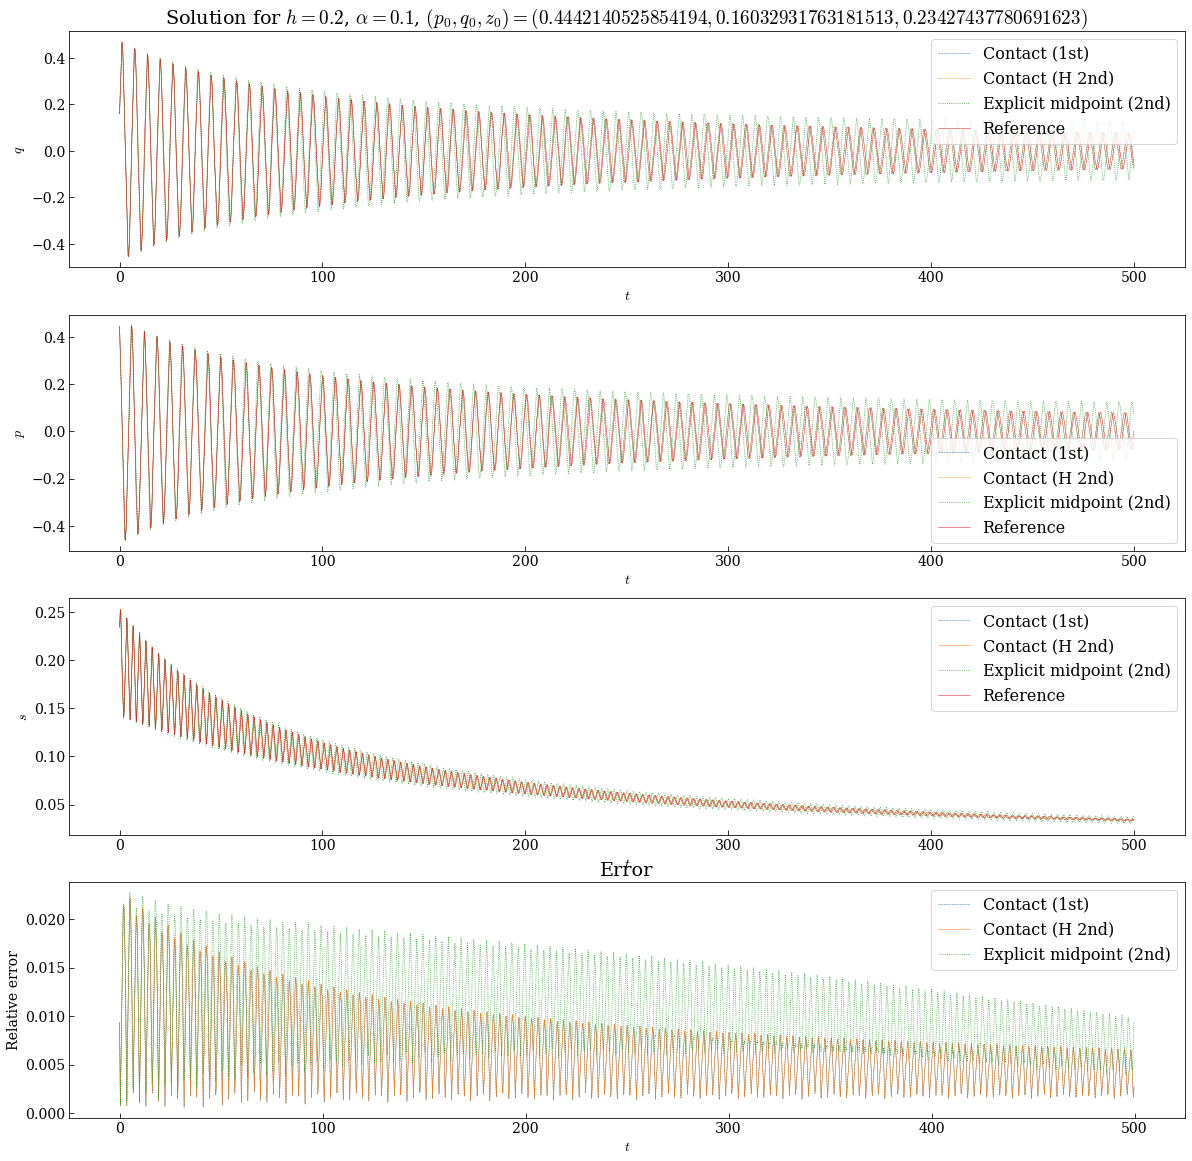

In [55]:
#init = (.5, -.7, -.2)
init = .5*np.random.rand(3)
tspan = (0.0, 500.0)
a = .1
h = 0.2
delta = 10

cmp_plot(init, tspan, a, h, delta)

#quadratic(init, np.arange(0.0, 50.0, 0.3), a, 0.2)

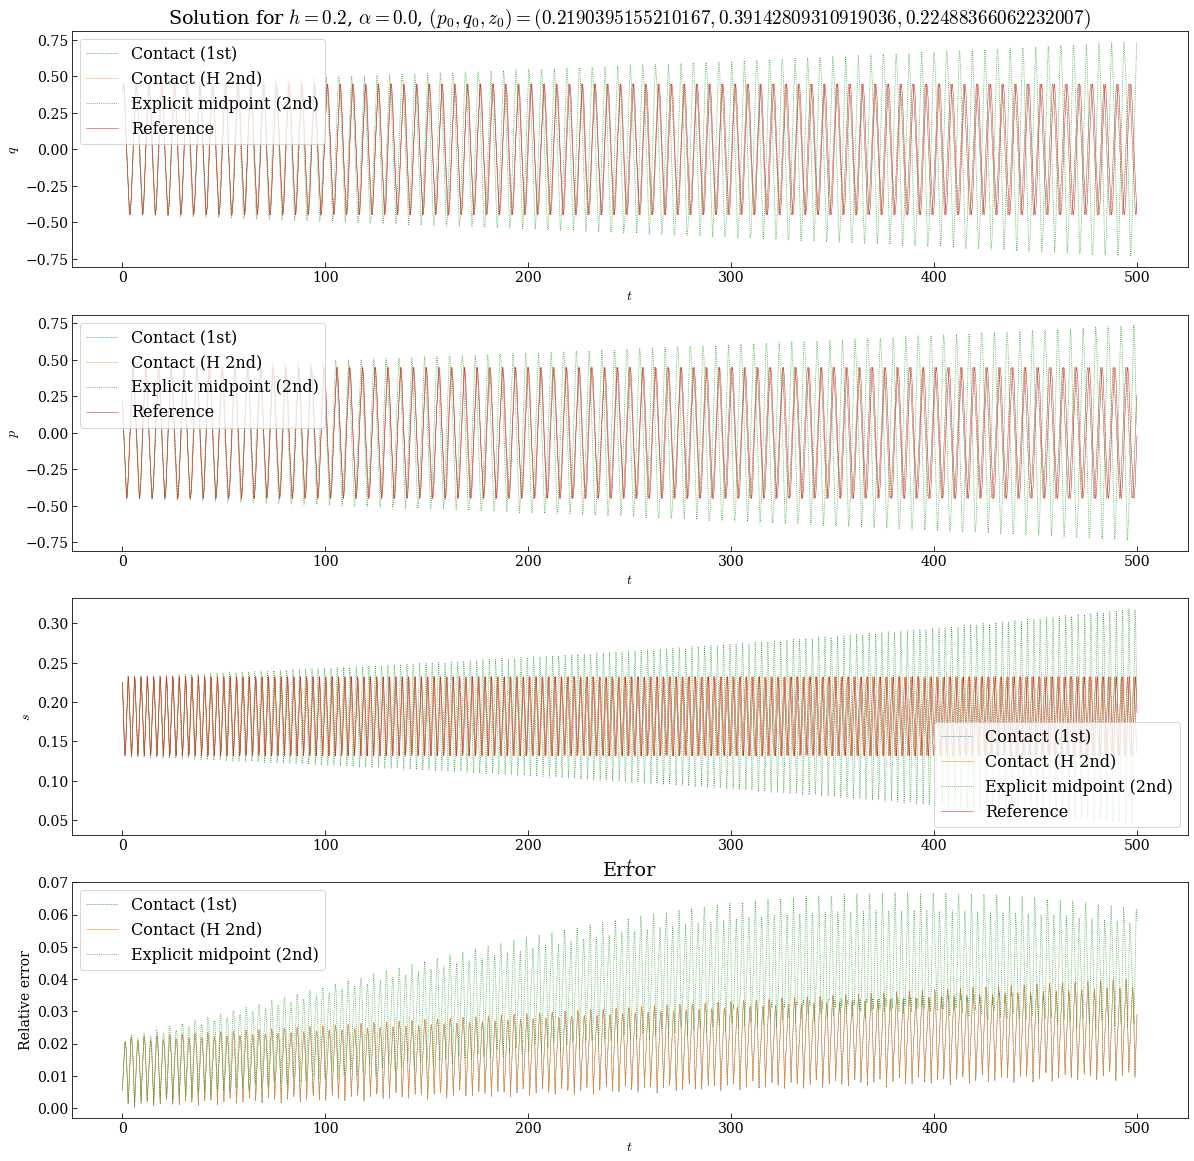

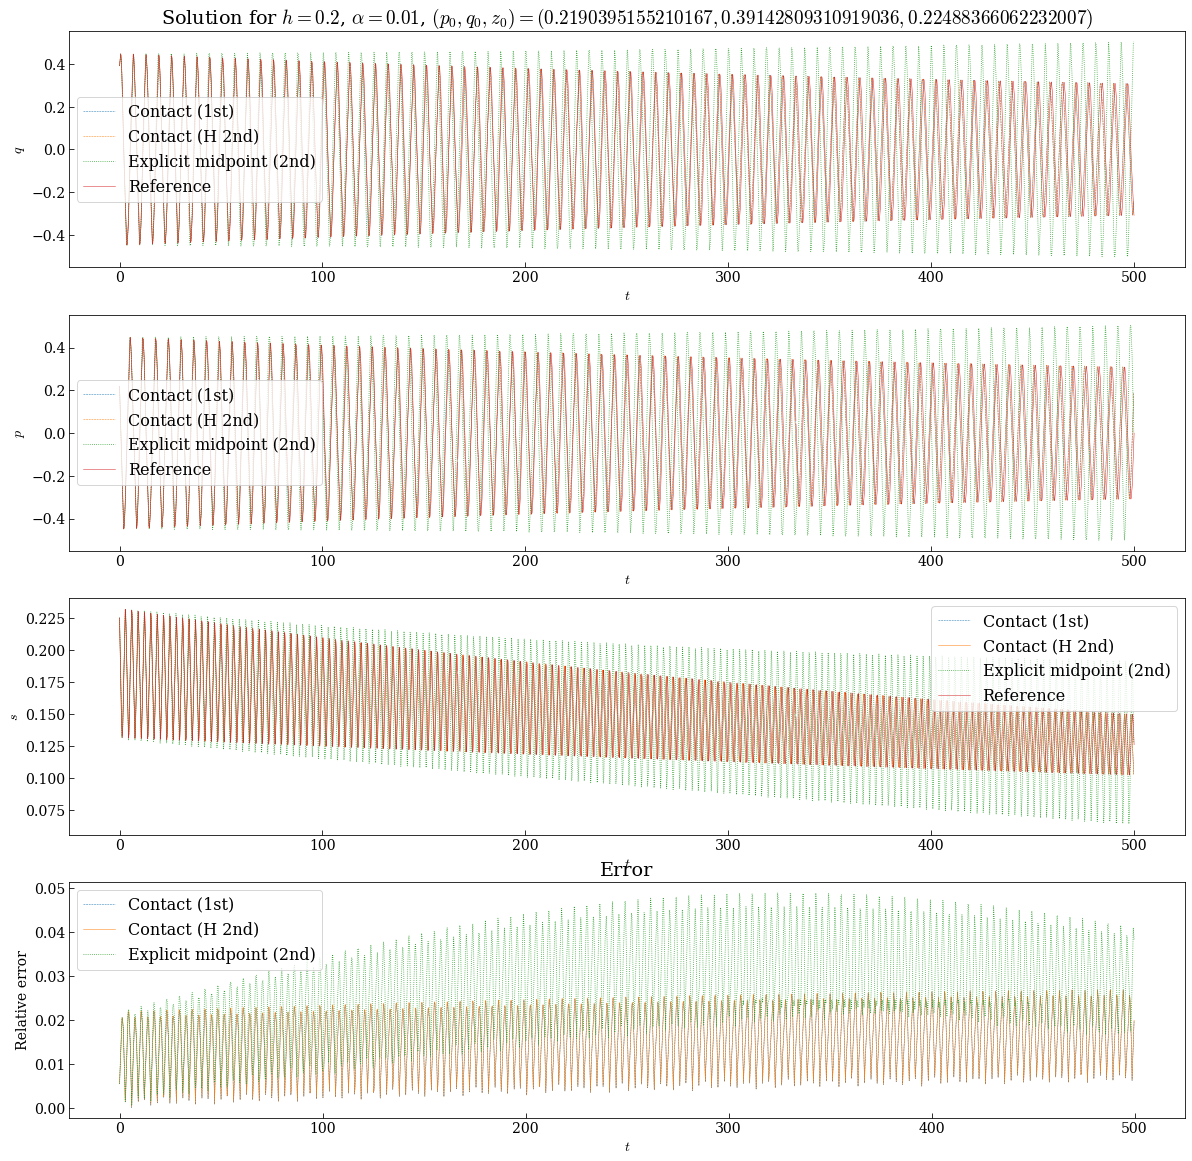

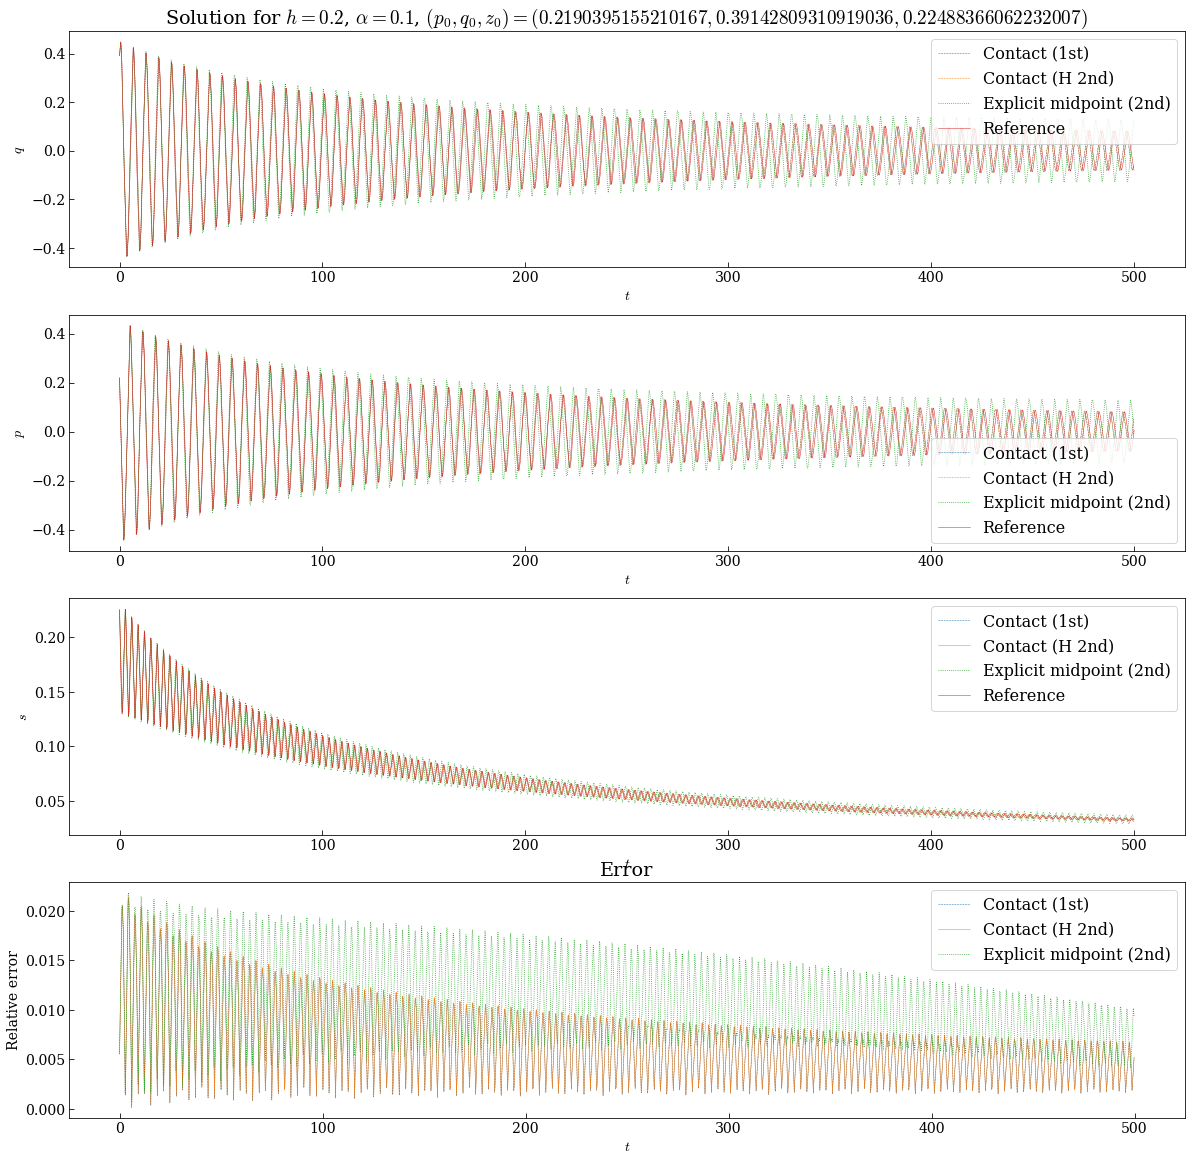

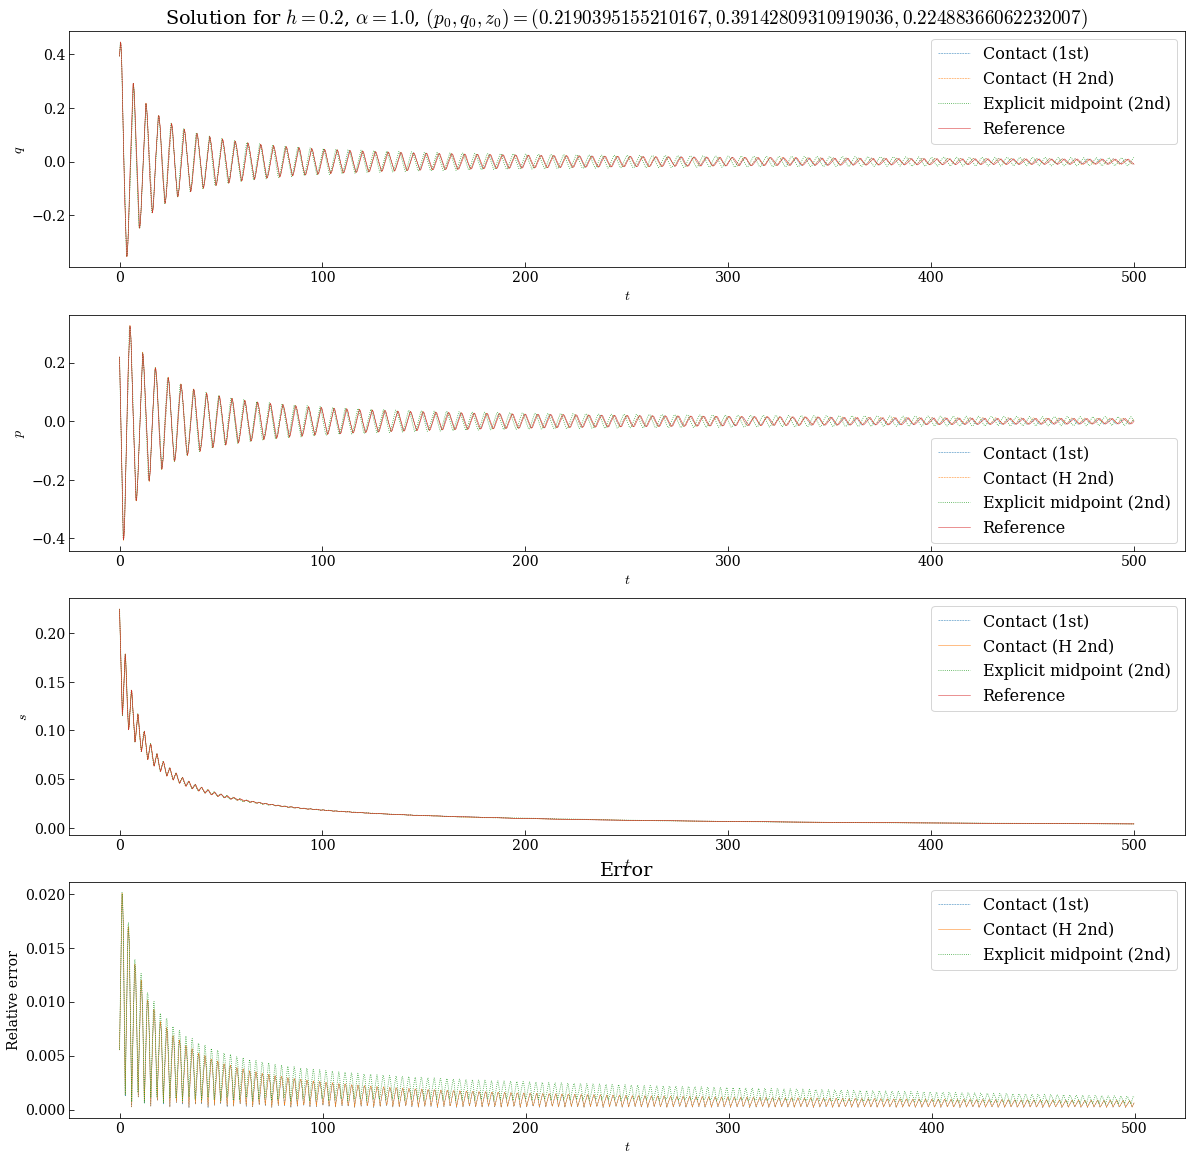

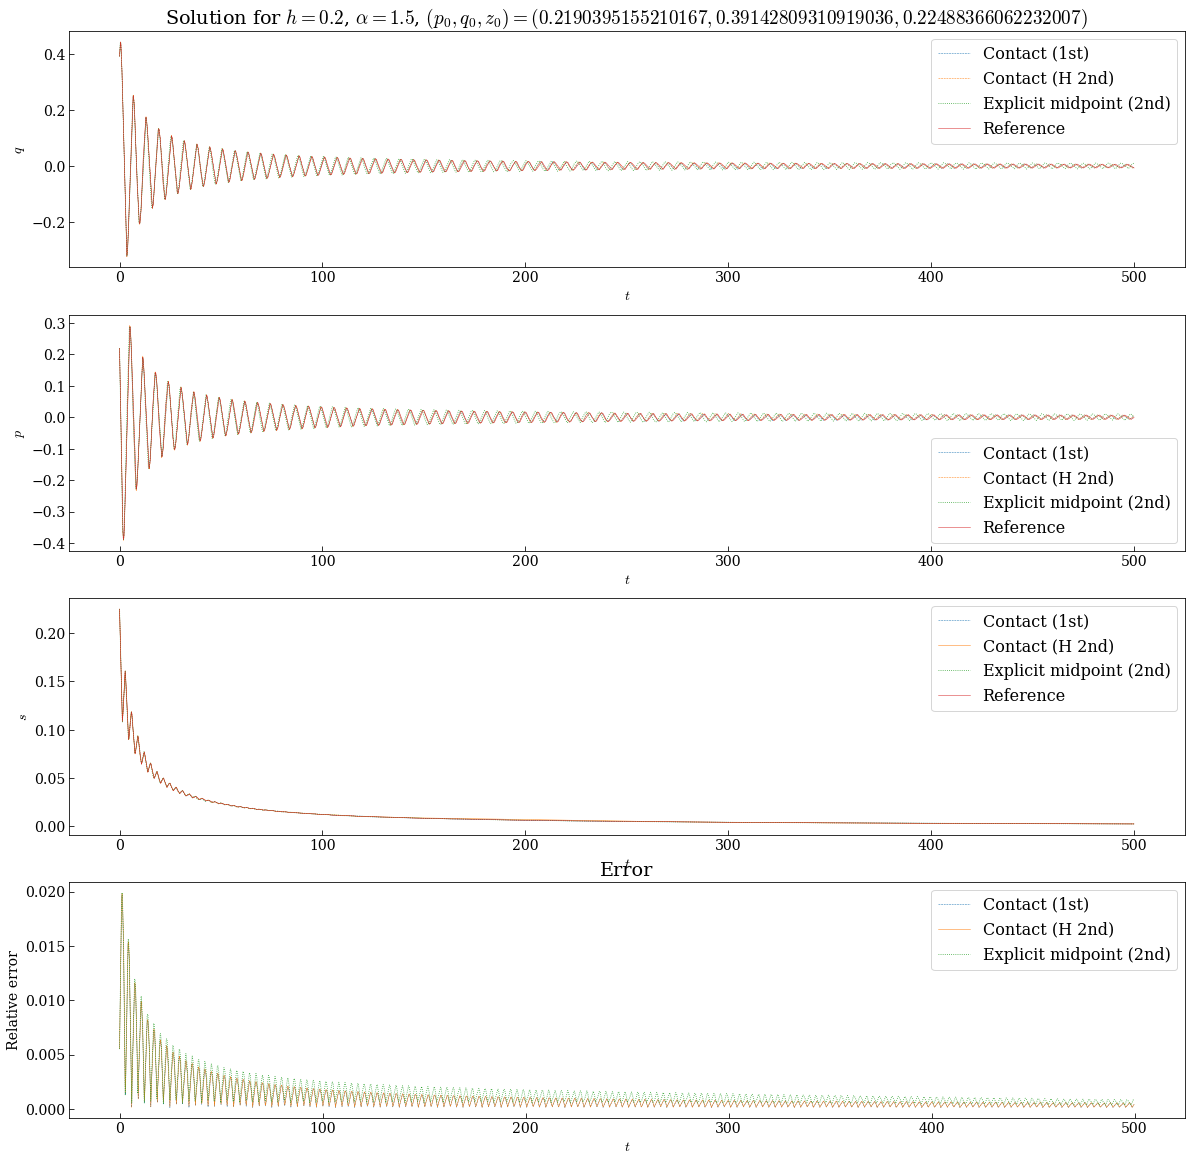

In [56]:
init = 0.5*np.random.rand(3)
#init = (.5, -.7, .2)
tspan = (0.0, 500.0)
delta = 10
    
for a in [0.0, 0.01, 0.1, 1.0, 1.5]:
    for h in [.2]:
        cmp_plot(init, tspan, a, h, delta)

In [10]:
t0, tf = (0., 50.)
h = 0.1
a = 1.0
C = 18
ts = np.arange(t0, tf, h)

/opt/local/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


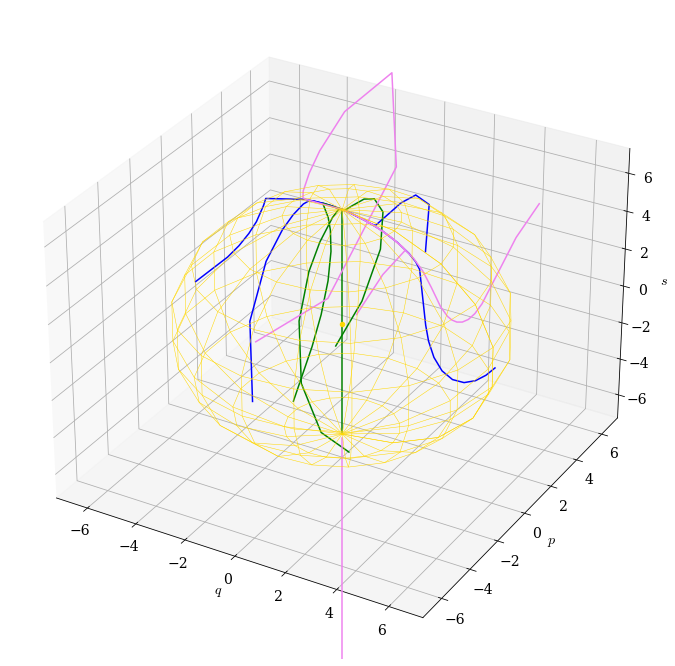

In [11]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')

for init in [
    #(2, -3, -2), (2, 0, -2), (-2, 1, -3)
     (0,0,6), (0,0,-6), (6,0,0), (0,6,0)
    , (-6, 0, 0) , (0, -6, 0)
    , (0,0,-5.9)
    , (0,-2,-5), (3,-2,-4), (-3,2,-4)
    , (5,5,5), (4, -6, -6), (-6, 4, 6)
    , (0,0, -6.2)
    ]:
    sol, sols, _ = quadratic_v(init, ts, a, C=C)
    x,y,z = init
    n = x**2 + y**2 + z**2
    if n == 36:
        color="blue"
    elif n < 36:
        color="green"
    else:
        color="violet"
    ax.plot(sol[:,1], sol[:,0], sols, label="({},{},{})".format(*init), color=color, linewidth=1.5)
    #solm = midpoint(init, ts, a, h, acc=osc, C=C)
    #ax.plot(solm[:,1], solm[:,0], solm[:,2], color="b", linewidth=0.1)

u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.sqrt(2.*C)*np.cos(u)*np.sin(v)
y = np.sqrt(2.*C)*np.sin(u)*np.sin(v)
z = np.sqrt(2.*C)*np.cos(v)
ax.plot_wireframe(x, y, z, color="gold", linewidth=0.5)

ax.scatter([0],[0],[0], color="gold")

ax.set_xlabel('$q$')
ax.set_ylabel('$p$')
ax.set_zlabel('$s$')
ax.set_xlim(-7,7)
ax.set_ylim(-7,7)
ax.set_zlim(-7,7)

#plt.legend()
plt.savefig("images/sphere.pdf", transparent=True, bbox_inches='tight')
plt.show()

<ipython-input-5-dc6b7850e6e8>:1: RuntimeWarning: overflow encountered in double_scalars
  osc = lambda p,x,z,t,a: -x-a*p*z
<ipython-input-5-dc6b7850e6e8>:5: RuntimeWarning: overflow encountered in double_scalars
  lag = lambda p,q,z: p**2/2.0 - q**2/2.0 + C - a*z**2/2.0
<ipython-input-5-dc6b7850e6e8>:5: RuntimeWarning: invalid value encountered in double_scalars
  lag = lambda p,q,z: p**2/2.0 - q**2/2.0 + C - a*z**2/2.0


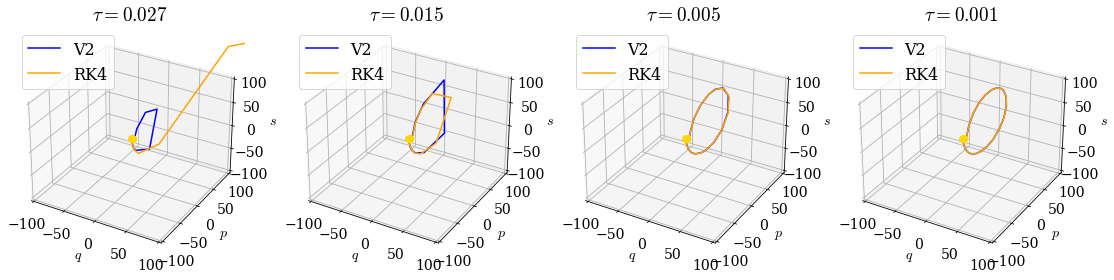

(q,p,s)=(0,-1,-7)


In [12]:
init = (0, -1, -7)
fig = plt.figure(figsize=(24,6))

for i, dt in enumerate([.027, .015, .005, .001]):
    ax = fig.add_subplot(1, 5, i+1, projection='3d')
    
    tsl = np.arange(t0, tf/10, dt)
    sol, sols, _ = quadratic_v(init, tsl, a, C=C)
    ax.plot(sol[:,1], sol[:,0], sols, label="V2", color="blue")
    solm = rk4s(init, tsl, a, h, acc=osc, C=C)
    ax.plot(solm[:,1], solm[:,0], solm[:,2], label="RK4", color="orange")

    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = np.sqrt(2.*C)*np.cos(u)*np.sin(v)
    y = np.sqrt(2.*C)*np.sin(u)*np.sin(v)
    z = np.sqrt(2.*C)*np.cos(v)
    ax.plot_wireframe(x, y, z, color="gold", linewidth=0.5)

    ax.scatter([0],[0],[0], color="gold")

    ax.set_xlabel('$q$')
    ax.set_ylabel('$p$')
    ax.set_zlabel('$s$')
    ax.set_xlim(-100,100)
    ax.set_ylim(-100,100)
    ax.set_zlim(-100,100)
    ax.set_title("$\\tau={}$".format(dt))
    
    plt.legend()

plt.savefig("images/sph-{}_{}_{}.pdf".format(*init), transparent=True, bbox_inches='tight')
plt.show()
print("(q,p,s)=({},{},{})".format(*init))